#### Grab a random molecule from FreeSolv, parameterize with OpenFF 1.2.0, generate some configuration snapshots

In [1]:
import openforcefield
openforcefield.__version__

'0.8.0'

In [2]:
from openforcefield.topology import Molecule
from openforcefield.typing.engines.smirnoff import ForceField
forcefield = ForceField('openff-1.2.0.offxml')

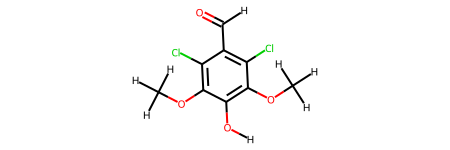

In [3]:
# random molecule from freesolv database.txt
# https://github.com/MobleyLab/FreeSolv/blob/ff0961a3177863c8002e8487ff9718c513974138/database.txt#L397
offmol = Molecule.from_smiles('COc1c(c(c(c(c1Cl)C=O)Cl)OC)O')
offmol

In [4]:
offmol.compute_partial_charges_am1bcc()

In [5]:
offmol.generate_conformers()

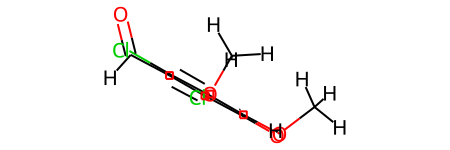

In [6]:
offmol.to_rdkit()

In [7]:
len(offmol.conformers)

1

In [8]:
sys = forcefield.create_openmm_system(offmol.to_topology())
top = offmol.to_topology().to_openmm()

In [9]:
from simtk import unit
from simtk import openmm as mm
from simtk.openmm import app


temperature = 300 * unit.kelvin
gamma = 100.0 / unit.picosecond
dt = 1.0 * unit.femtosecond

sim = app.Simulation(top, sys, mm.LangevinIntegrator(temperature, gamma, dt))

In [10]:
off_charges = offmol.partial_charges

In [11]:
nb_force = sys.getForce(0)
nb_force

<simtk.openmm.openmm.NonbondedForce; proxy of <Swig Object of type 'OpenMM::NonbondedForce *' at 0x7f82315ecd80> >

In [12]:
N = offmol.n_atoms
N

23

In [13]:
omm_charges = []
for i in range(N):
    omm_charges.append(nb_force.getParticleParameters(i)[0])

In [14]:
charge_differences = [omm_charges[i] - off_charges[i] for i in range(N)]
charge_differences

[Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementary charge),
 Quantity(value=0.0, unit=elementa

In [15]:
sim.context.setPositions(offmol.conformers[0])

In [16]:
def get_energy():
    return sim.context.getState(getEnergy=True).getPotentialEnergy()

In [17]:
get_energy()

Quantity(value=258.4339904785156, unit=kilojoule/mole)

In [18]:
sim.minimizeEnergy()

In [19]:
get_energy()

Quantity(value=242.51620483398438, unit=kilojoule/mole)

In [20]:
sim.context.setVelocitiesToTemperature(temperature)

In [21]:
def get_positions():
    return sim.context.getState(getPositions=True).getPositions(asNumpy=True)

In [22]:
get_positions()

Quantity(value=array([[ 0.25787252,  0.02050192, -0.19939502],
       [ 0.20957561, -0.10400783, -0.14720073],
       [ 0.19580406, -0.10378213, -0.0098293 ],
       [ 0.29582617, -0.16354832,  0.06761356],
       [ 0.28628427, -0.16435738,  0.20790081],
       [ 0.1743831 , -0.10668242,  0.27013183],
       [ 0.07211669, -0.04751066,  0.19314739],
       [ 0.0823373 , -0.04789897,  0.0519701 ],
       [-0.04737184,  0.01389246, -0.04980485],
       [-0.04333544,  0.0122078 ,  0.26227048],
       [-0.10133274,  0.11306173,  0.22370285],
       [ 0.16506597, -0.1072682 ,  0.44578177],
       [ 0.38360867, -0.22357166,  0.28573391],
       [ 0.50545275, -0.14874387,  0.29327917],
       [ 0.40126154, -0.22257276,  0.00262366],
       [ 0.26751426,  0.01357658, -0.30817151],
       [ 0.35597834,  0.04417292, -0.15710716],
       [ 0.18885079,  0.10214639, -0.1760828 ],
       [-0.0755612 , -0.02902563,  0.35737294],
       [ 0.57527167, -0.19916944,  0.36076942],
       [ 0.48599979, -0.0

In [23]:
%%time
sim.step(10000)

CPU times: user 151 ms, sys: 87.4 ms, total: 238 ms
Wall time: 377 ms


In [24]:
from espaloma.units import DISTANCE_UNIT, ENERGY_UNIT

Using backend: pytorch


In [25]:
import torch
torch.set_default_dtype(torch.float64)

import numpy as np

In [26]:
from tqdm import tqdm
xyz = []
vacuum_energies = []

n_samples = 100

for _ in tqdm(range(n_samples)):
    sim.step(100)
    xyz.append(get_positions().value_in_unit(DISTANCE_UNIT))
    vacuum_energies.append(get_energy().value_in_unit(ENERGY_UNIT))
vacuum_energies = torch.tensor(vacuum_energies)

100%|██████████| 100/100 [00:01<00:00, 52.36it/s]


In [27]:
print(DISTANCE_UNIT)

bohr


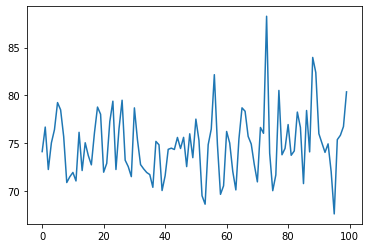

In [28]:
import matplotlib.pyplot as plt

plt.plot((vacuum_energies * ENERGY_UNIT).value_in_unit(unit.kilocalorie_per_mole))

In [29]:
N = len(xyz[0])
N

23

#### Pre-compute pairwise distance matrices

In [30]:
xyz[0]

array([[ 5.13079831,  0.37707749, -3.61769059],
       [ 3.45578695, -1.6319182 , -2.61019242],
       [ 3.27907415, -1.34603435,  0.01495269],
       [ 5.09139414, -2.3715873 ,  1.79347478],
       [ 4.88193708, -1.88983091,  4.33868104],
       [ 2.91588522, -0.44734937,  5.20251845],
       [ 0.92807173,  0.46561115,  3.54189414],
       [ 1.09544837, -0.08531871,  0.95705879],
       [-1.24126035,  1.0973458 , -1.29162954],
       [-1.09961571,  1.96412788,  4.75214834],
       [-2.92377963,  2.8172064 ,  3.62656691],
       [ 2.73898207,  0.1309265 ,  8.34914339],
       [ 6.72010939, -2.8629965 ,  5.94520606],
       [ 9.35970246, -2.14917676,  5.79030503],
       [ 7.06878792, -3.84256364,  0.72443501],
       [ 4.46755432,  0.79518056, -5.53107054],
       [ 7.02870962, -0.43061758, -3.76371868],
       [ 5.02550914,  2.19835609, -2.64425284],
       [-1.03367059,  2.37045136,  6.76172574],
       [ 9.59847316, -0.17646875,  6.36229885],
       [ 9.93839984, -2.20829218,  3.806

In [31]:
from scipy.spatial.distance import pdist, squareform

# these are espaloma units of bohr
distance_matrices = [torch.tensor(squareform(pdist(conf))) for conf in xyz]
distance_matrices = torch.stack(distance_matrices)

In [32]:
(torch.median(distance_matrices[0]) * DISTANCE_UNIT).value_in_unit(unit.angstrom)

tensor(3.9018)

In [33]:
radii = 1.2 * (torch.ones(N) * unit.angstroms).value_in_unit(DISTANCE_UNIT)
scales = 0.8 * torch.ones(N)

In [34]:
radii.shape, scales.shape

(torch.Size([23]), torch.Size([23]))

In [35]:
radii, scales

(tensor([2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677,
         2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677,
         2.2677, 2.2677, 2.2677, 2.2677, 2.2677]),
 tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000,
         0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000,
         0.8000, 0.8000, 0.8000, 0.8000, 0.8000]))

In [36]:
offmol.partial_charges

Quantity(value=array([ 0.11063   , -0.32578999,  0.04101   ,  0.13609999,  0.04101   ,
        0.06506   , -0.19729   ,  0.06506   , -0.04672   ,  0.58569002,
       -0.49212   , -0.04672   , -0.32578999,  0.11063   , -0.4727    ,
        0.04844   ,  0.04844   ,  0.04844   ,  0.02066   ,  0.04844   ,
        0.04844   ,  0.04844   ,  0.44064   ]), unit=elementary charge)

In [37]:
charges = torch.tensor([c / unit.elementary_charge for c in off_charges])

#### Compute hydration free energy difference using EXP


In [38]:
from espaloma.mm.implicit import gbsa_obc2_energy

In [39]:
def compute_obc2_energies(distance_matrices, radii, scales, charges):
    N = len(distance_matrices)
    E_s = torch.zeros(N)
    for i in range(N):
        E_s[i] += gbsa_obc2_energy(
            distance_matrices[i],
            radii, scales, charges
        )
    return E_s

In [40]:
len(distance_matrices)

100

In [41]:
obc2_energies = compute_obc2_energies(distance_matrices, radii, scales, charges)

In [42]:
obc2_energies

tensor([0.0124, 0.0125, 0.0123, 0.0122, 0.0123, 0.0120, 0.0121, 0.0122, 0.0122,
        0.0122, 0.0121, 0.0122, 0.0119, 0.0122, 0.0121, 0.0123, 0.0122, 0.0124,
        0.0120, 0.0123, 0.0121, 0.0121, 0.0124, 0.0123, 0.0121, 0.0119, 0.0122,
        0.0122, 0.0122, 0.0122, 0.0122, 0.0123, 0.0122, 0.0121, 0.0120, 0.0122,
        0.0122, 0.0124, 0.0121, 0.0122, 0.0124, 0.0123, 0.0122, 0.0122, 0.0123,
        0.0121, 0.0121, 0.0122, 0.0122, 0.0122, 0.0122, 0.0122, 0.0120, 0.0122,
        0.0121, 0.0123, 0.0120, 0.0121, 0.0120, 0.0122, 0.0122, 0.0123, 0.0122,
        0.0121, 0.0121, 0.0122, 0.0122, 0.0121, 0.0122, 0.0121, 0.0122, 0.0122,
        0.0120, 0.0121, 0.0122, 0.0123, 0.0122, 0.0122, 0.0123, 0.0122, 0.0122,
        0.0122, 0.0121, 0.0123, 0.0124, 0.0122, 0.0120, 0.0121, 0.0120, 0.0122,
        0.0123, 0.0123, 0.0123, 0.0120, 0.0121, 0.0122, 0.0121, 0.0121, 0.0122,
        0.0122])

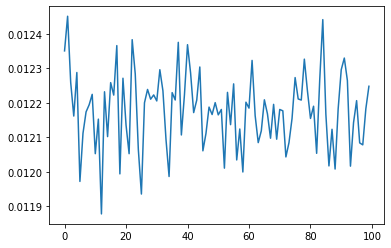

In [43]:
plt.plot(obc2_energies.detach().numpy())

In [44]:
radii

tensor([2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677,
        2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677, 2.2677,
        2.2677, 2.2677, 2.2677, 2.2677, 2.2677])

In [45]:
from openmmtools.constants import kB
kT = kB * temperature

In [46]:
to_kT = 1.0 * ENERGY_UNIT / kT
to_kT

1052.5821686494048

In [47]:
w = obc2_energies * to_kT
w

tensor([13.0001, 13.1058, 12.9038, 12.8013, 12.9341, 12.6018, 12.7487, 12.8138,
        12.8355, 12.8674, 12.6864, 12.7918, 12.5026, 12.8753, 12.7385, 12.9032,
        12.8652, 13.0162, 12.6248, 12.9166, 12.7741, 12.6864, 13.0343, 12.9294,
        12.6996, 12.5633, 12.8416, 12.8824, 12.8527, 12.8657, 12.8474, 12.9426,
        12.8783, 12.7297, 12.6168, 12.8727, 12.8503, 13.0262, 12.7435, 12.8659,
        13.0190, 12.9325, 12.8118, 12.8499, 12.9509, 12.6951, 12.7481, 12.8286,
        12.8059, 12.8421, 12.8049, 12.8213, 12.6423, 12.8735, 12.7750, 12.8994,
        12.6673, 12.7617, 12.6306, 12.8435, 12.8255, 12.9710, 12.8027, 12.7202,
        12.7561, 12.8508, 12.8079, 12.7336, 12.8369, 12.7306, 12.8214, 12.8172,
        12.6765, 12.7201, 12.7940, 12.9186, 12.8534, 12.8501, 12.9749, 12.8785,
        12.7939, 12.8312, 12.6875, 12.9110, 13.0955, 12.8070, 12.6491, 12.7609,
        12.6395, 12.8231, 12.9427, 12.9782, 12.9097, 12.6484, 12.7810, 12.8483,
        12.7193, 12.7134, 12.8232, 12.89

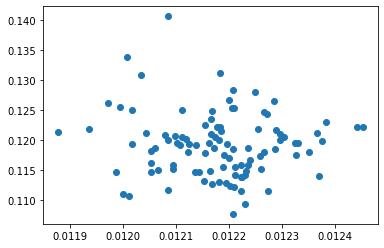

In [48]:
plt.scatter(obc2_energies, vacuum_energies)

(array([ 1.,  3.,  8., 14., 13., 27., 18.,  9.,  5.,  2.]),
 array([12.50262377, 12.56293923, 12.62325469, 12.68357015, 12.74388561,
        12.80420107, 12.86451653, 12.92483199, 12.98514745, 13.04546291,
        13.10577836]),
 <BarContainer object of 10 artists>)

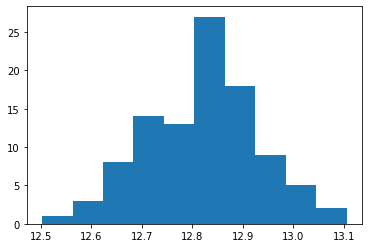

In [49]:
plt.hist(w.detach().flatten().numpy())

In [50]:
w.detach().flatten().numpy().std()

0.11397881144672393

In [51]:
def one_sided_exp(w):
    delta_f = - (torch.logsumexp(- w, dim=(0,)) - np.log(len(w)))
    return delta_f

In [52]:
w.mean()

tensor(12.8183)

In [53]:
torch.logsumexp(w, dim=(0,))

tensor(17.4300)

In [54]:
from scipy.special import logsumexp
logsumexp(w)

17.42998592798577

In [55]:
%%time
one_sided_exp(w)

CPU times: user 726 µs, sys: 671 µs, total: 1.4 ms
Wall time: 738 µs


tensor(12.8118)

In [56]:
((one_sided_exp(w) / to_kT).detach() * ENERGY_UNIT).value_in_unit(unit.kilocalorie_per_mole)

tensor(7.6379)

In [57]:
expt_delta_f = -8.68 * unit.kilocalorie_per_mole / kT
expt_delta_f

-14.559801248448967

In [58]:
radii.requires_grad_()
scales.requires_grad_()

tensor([0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000, 0.8000,
        0.8000, 0.8000, 0.8000, 0.8000, 0.8000], requires_grad=True)

In [59]:
sum([c.value_in_unit(unit.elementary_charge) for c in off_charges])

1.6763806343078613e-08

In [60]:
#def free_energy_loss(distance_matrices, radii, scales, charges):
#    w = compute_obc2_energies(distance_matrices, radii, scales, charges) - vacuum_energies
#    pred_delta_f = one_sided_exp(w)
#    return torch.sqrt((pred_delta_f - expt_delta_f)**2)

In [61]:
# NOTE: compilation time blows up because it attempts to inline the entire
# loop over the training data...
#fast_free_energy_loss = torch.jit.trace(
#    free_energy_loss,
#    (distance_matrices, radii, scales, charges),
#)

In [62]:
def free_energy_loss(radii, scales, charges, inds):
    """compute hydration free energy using the subset of snapshots indexed by inds"""
    solv_energies = compute_obc2_energies(distance_matrices[inds], radii, scales, charges)
    W = solv_energies
    w = W * to_kT
    pred_delta_f = one_sided_exp(w)
    return torch.sqrt((pred_delta_f - expt_delta_f)**2)

#### Check ability to fit to expt free energy target if all radii and scales are free parameters

In [63]:
radii = (torch.ones(N) * unit.angstroms).value_in_unit(DISTANCE_UNIT)
scales = torch.ones(N)
radii, scales

(tensor([1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
         1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897, 1.8897,
         1.8897, 1.8897, 1.8897, 1.8897, 1.8897]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1.]))

In [64]:
radii.requires_grad_()
scales.requires_grad_()

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.], requires_grad=True)

In [65]:
learning_rate = 1e-3
optimizer = torch.optim.Adam([radii, scales], lr=learning_rate)

In [66]:
distance_matrices.shape

torch.Size([100, 23, 23])

In [67]:
radii_traj = [np.array(radii.detach().numpy())]
scales_traj = [np.array(scales.detach().numpy())]

n_snapshots_per_batch = 25
batch_losses = []
trange = tqdm(range(1000))
for t in trange:
    batch_inds = np.random.choice(range(len(distance_matrices)), n_snapshots_per_batch)
    L = free_energy_loss(radii, scales, charges, batch_inds)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    trange.set_postfix(batch_loss=batch_losses[-1])
    
    
    radii_traj.append(np.array(radii.detach().numpy()))
    scales_traj.append(np.array(scales.detach().numpy()))

100%|██████████| 1000/1000 [00:58<00:00, 17.23it/s, batch_loss=14.517096106729873]


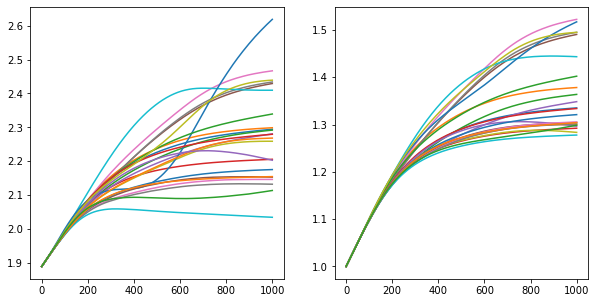

In [68]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.array(radii_traj))
plt.subplot(1,2,2)
plt.plot(np.array(scales_traj))

In [69]:
loss_traj_in_kcalmol = [(b * kT).value_in_unit(unit.kilocalorie_per_mole) for b in batch_losses]

(0.0, 14.765418564540159)

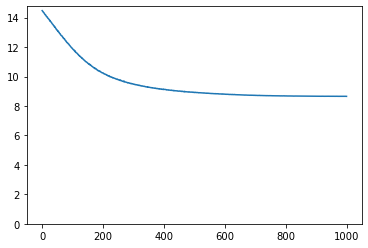

In [70]:
plt.plot(loss_traj_in_kcalmol)
plt.ylim(0,)

#### Double-check estimate variance under configuration subsampling

In [71]:
losses = []
for _ in tqdm(range(100)):
    batch_inds = np.random.choice(range(len(distance_matrices)), n_snapshots_per_batch)
    L = float(free_energy_loss(radii, scales, charges, batch_inds).detach())
    losses.append(L)

100%|██████████| 100/100 [00:02<00:00, 38.35it/s]


Text(0, 0.5, 'frequency')

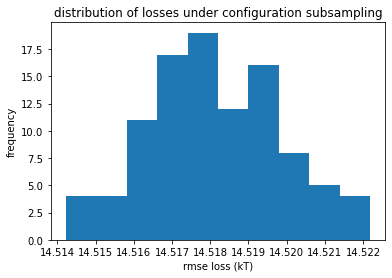

In [72]:
plt.title('distribution of losses under configuration subsampling')
plt.hist(losses);
plt.xlabel('rmse loss (kT)')
plt.ylabel('frequency')

#### Now let's get a graph net in the mix!

In [73]:
from espaloma.redux.nn import TAG, MLP
from espaloma.redux.symmetry import ValenceModel, Readouts, elements

def initialize(hidden_dim=128, node_dim=128):
    node_representation = TAG(in_dim=len(elements), hidden_dim=hidden_dim, out_dim=node_dim)
    readouts = Readouts(atoms=MLP(node_dim, 2), bonds=MLP(2 * node_dim, 2), angles=MLP(3 * node_dim, 2),
                        propers=MLP(4 * node_dim, 6), impropers=MLP(4 * node_dim, 6))
    valence_model = ValenceModel(node_representation, readouts)
    return valence_model

In [74]:
valence_model = initialize()

In [75]:
params = valence_model.forward(offmol)

In [76]:
radii = params.atoms[:,0]
scales = params.atoms[:,1]
radii, scales

(tensor([ 0.0154,  0.0042,  0.0125,  0.0106,  0.0125,  0.0142,  0.0079,  0.0142,
          0.0018,  0.0125, -0.0003,  0.0018,  0.0042,  0.0154,  0.0071, -0.0024,
         -0.0024, -0.0024,  0.0041, -0.0024, -0.0024, -0.0024,  0.0009],
        grad_fn=<SelectBackward>),
 tensor([-0.0625, -0.0412, -0.0451, -0.0491, -0.0451, -0.0466, -0.0478, -0.0466,
         -0.0387, -0.0456, -0.0387, -0.0387, -0.0412, -0.0625, -0.0386, -0.0522,
         -0.0522, -0.0522, -0.0464, -0.0522, -0.0522, -0.0522, -0.0518],
        grad_fn=<SelectBackward>))

In [77]:
def predict_obc2_params(offmol):
    """output of graph net's atom representation will initially be near zero, just offset by +1"""
    params = valence_model.forward(offmol)
    radii = params.atoms[:,0] + 1
    scales = params.atoms[:,1] + 1
    return radii, scales

In [78]:
radii, scales = predict_obc2_params(offmol)
radii, scales

(tensor([1.0154, 1.0042, 1.0125, 1.0106, 1.0125, 1.0142, 1.0079, 1.0142, 1.0018,
         1.0125, 0.9997, 1.0018, 1.0042, 1.0154, 1.0071, 0.9976, 0.9976, 0.9976,
         1.0041, 0.9976, 0.9976, 0.9976, 1.0009], grad_fn=<AddBackward0>),
 tensor([0.9375, 0.9588, 0.9549, 0.9509, 0.9549, 0.9534, 0.9522, 0.9534, 0.9613,
         0.9544, 0.9613, 0.9613, 0.9588, 0.9375, 0.9614, 0.9478, 0.9478, 0.9478,
         0.9536, 0.9478, 0.9478, 0.9478, 0.9482], grad_fn=<AddBackward0>))

In [79]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(valence_model.parameters(), lr=learning_rate)

In [80]:
radii_traj = [np.array(radii.detach().numpy())]
scales_traj = [np.array(scales.detach().numpy())]

batch_losses = []
trange = tqdm(range(1000))

n_snapshots_per_batch = 25

for t in trange:
    batch_inds = np.random.choice(range(len(distance_matrices)), n_snapshots_per_batch)
    
    radii, scales = predict_obc2_params(offmol)
    L = free_energy_loss(radii, scales, charges, batch_inds)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    batch_losses.append(L.detach().numpy())
    trange.set_postfix(batch_loss=batch_losses[-1])
    
    
    radii_traj.append(np.array(radii.detach().numpy()))
    scales_traj.append(np.array(scales.detach().numpy()))

100%|██████████| 1000/1000 [01:28<00:00, 11.32it/s, batch_loss=14.543289576310553]


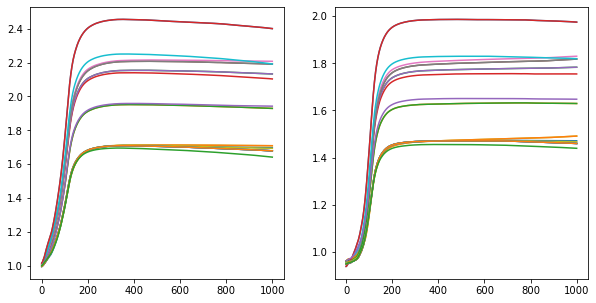

In [81]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(np.array(radii_traj))
plt.subplot(1,2,2)
plt.plot(np.array(scales_traj))

Text(0, 0.5, 'hydration free energy error (kcal/mol)')

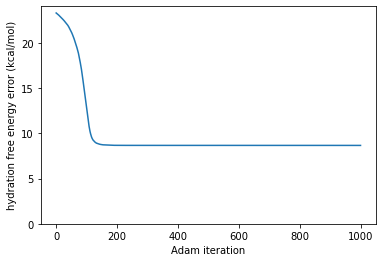

In [82]:
loss_traj_in_kcalmol = [(b * kT).value_in_unit(unit.kilocalorie_per_mole) for b in batch_losses]
plt.plot(loss_traj_in_kcalmol)
plt.ylim(0,)
plt.xlabel('Adam iteration')
plt.ylabel('hydration free energy error (kcal/mol)')